## Model Building

### Imports

In [46]:
# src/data_preparation.py
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

### Functions

In [47]:
def DISPLAY_DF(df):
  print(f'Shape: {df.shape}')
  return df.head()

def evaluate_regression(y_true, y_pred, model_name="Model"):
    print(f"📊 Evaluation Metrics for {model_name}")
    print(f"🔢 MAE (Mean Absolute Error): {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"📉 MSE (Mean Squared Error): {mean_squared_error(y_true, y_pred):.4f}")
    print(f"📈 RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"🎯 R² Score: {r2_score(y_true, y_pred):.4f}")


def plot_loss_curve(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
    plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
    plt.title("📉 Training vs Validation Loss", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(8, 4))
    plt.plot(y_true[:100], label="Actual", marker='o', linestyle='-', alpha=0.7)
    plt.plot(y_pred[:100], label="Predicted", marker='x', linestyle='--', alpha=0.7)
    plt.title("📈 Actual vs Predicted (First 100)", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Load Input Data

In [ ]:
# Load the data

full_df = pd.read_parquet("data/training_data.gzip")

In [57]:
full_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'ticker', 'return',
       'ma5', 'ma10', 'ma20', 'vol_chg', 'volatility', 'rsi', 'macd',
       'momentum', 'dayofweek', 'month', 'day', 'is_month_start',
       'is_month_end', 'target'],
      dtype='object')

In [71]:
# 📊 Features & Target
features = ["return", "ma5", "ma10", "ma20", "vol_chg", "volatility", "rsi", "macd", "momentum"]
full_df = full_df.dropna(subset=features + ['target'])  # drop rows with any missing feature

target_col = "target"

### Model Preparation

#### Random Forest 🌲

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# features = ["return", "ma5", "ma10", "ma20", "vol_chg", "volatility", 'dayofweek', 'month', 'day', 'is_month_start']
X = full_df[features]
y = full_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

# 🏗 Train Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

In [73]:
evaluate_regression(y_test, y_pred_rf, model_name="Random Forest Regressor")

📊 Evaluation Metrics for Random Forest Regressor
🔢 MAE (Mean Absolute Error): 5.7817
📉 MSE (Mean Squared Error): 405.8061
📈 RMSE (Root Mean Squared Error): 20.1446
🎯 R² Score: 0.9906


#### GRU

In [80]:
# 🔁 Prepare Supervised Sequence Data
def create_sequences(data, target, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

# 🔄 Scale the Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_df[features + [target_col]])
X_all, y_all = create_sequences(scaled_data[:, :-1], scaled_data[:, -1], window_size=10)

# 📤 Train/Test Split
split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [66]:
# GRU Model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 🛑 Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 10, 64)         │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,841 (93.13 KB)

 Trainable params: 23,841 (93.13 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# 🚀 Train the Model
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 📈 Predict & Inverse Transform
y_pred = model.predict(X_test)
y_test_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1], y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_actual = scaler.inverse_transform(np.concatenate((X_test[:, -1], y_pred), axis=1))[:, -1]

Epoch 1/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0029 - val_loss: 3.2634e-04
Epoch 2/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 1.7135e-04 - val_loss: 2.4240e-04
Epoch 3/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 8.0663e-05 - val_loss: 4.3083e-04
Epoch 4/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 1.2148e-04 - val_loss: 2.2109e-04
Epoch 5/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 9.1915e-05 - val_loss: 1.9745e-04
Epoch 6/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 1.0918e-04 - val_loss: 2.0479e-04
Epoch 7/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 1.1285e-04 - val_loss: 1.8613e-04
Epoch 8/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0493e-04 - val_loss: 1.8874e-04
Epoch 9/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 7.7268e-05 - val_loss: 1.9652e-04
Epoch 10/50
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 7.9635e-05 - val_loss: 1.7792e-04
Epoch 11/50
1123/1123 ━

In [69]:
# 📊 Evaluation

evaluate_regression(y_test_actual, y_pred_actual, model_name="GRU Regressor")

📊 Evaluation Metrics for GRU Regressor
🔢 MAE (Mean Absolute Error): 7.9280
📉 MSE (Mean Squared Error): 632.1232
📈 RMSE (Root Mean Squared Error): 25.1421
🎯 R² Score: 0.9854


<ipython-input-47-9ad18204b674>:18: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


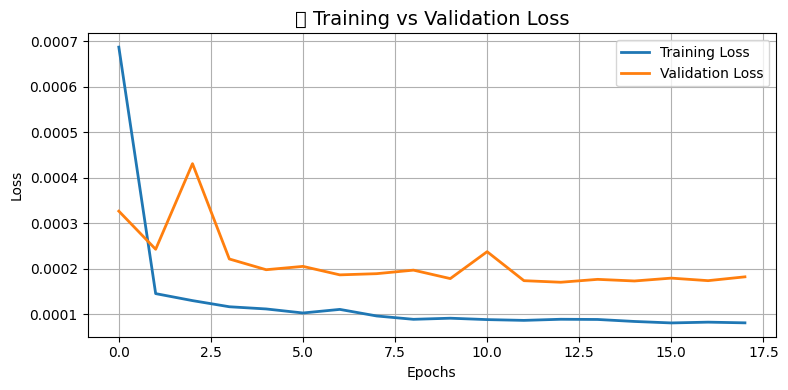

In [75]:
# Plot the loss curve
plot_loss_curve(history)  # Call the function from earlier

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


<ipython-input-47-9ad18204b674>:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


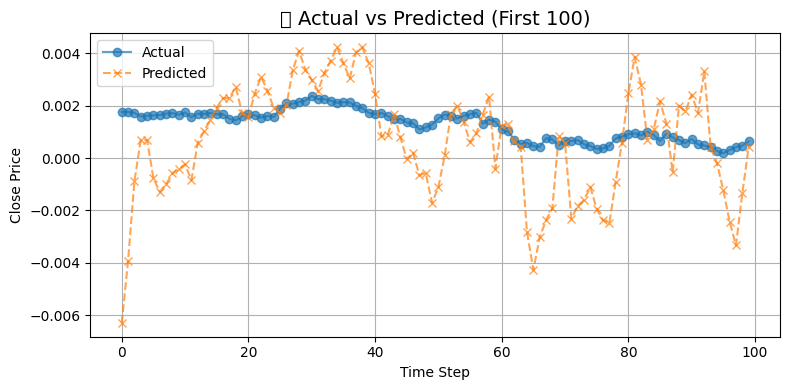

In [81]:
y_pred_gru = model.predict(X_test)
plot_actual_vs_predicted(y_test.flatten(), y_pred_gru.flatten())

### 📊 Observations

- **Random Forest Regressor** outperforms the GRU model across all key evaluation metrics:
  - **Lower MAE** and **RMSE**, indicating more accurate and consistent predictions.
  - **Higher R² Score**, suggesting better explained variance in the predicted close prices.
- Although GRU is a deep learning-based sequential model suitable for time series, it may:
  - Require more tuning, more data, or longer sequences to outperform classical models.
  - Be more sensitive to window size, sequence scaling, and architecture choices.

---

### ✅ Model Selection Recommendation

- **Preferred Model**: 🟢 **Random Forest Regressor**
- **Why?**
  - Simpler to train and tune.
  - Performs better in this setting despite being a non-sequential model.
  - Captures non-linear patterns and handles feature interactions well, which appears sufficient for predicting the next-day closing price.

> 🚀 Future Work:
> - Tune GRU/LSTM with more hyperparameters (e.g., units, layers, dropout).
> - Try hybrid models (e.g., feature engineering with RF + GRU on residuals).
> - Explore advanced architectures like TCNs or Transformers for deeper temporal understanding.

### Evaulate for Each Ticker

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Get unique tickers
tickers = full_df["ticker"].unique()

# Store results
results = []

for ticker in tickers:
    df_t = full_df[full_df["ticker"] == ticker].copy()

    # Sort & drop missing values
    df_t = df_t.sort_values("date").dropna()

    # Features and target
    X_t = df_t[features]
    y_t = df_t["target"]  # Assuming 'close' is your target for regression

    # Split
    split_idx = int(len(X_t) * 0.8)
    X_train_t, X_test_t = X_t[:split_idx], X_t[split_idx:]
    y_train_t, y_test_t = y_t[:split_idx], y_t[split_idx:]

    # Predict using global regressor
    y_pred_t = rf_reg.predict(X_test_t)

    # Evaluation
    mae = mean_absolute_error(y_test_t, y_pred_t)
    mse = mean_squared_error(y_test_t, y_pred_t)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_t, y_pred_t)

    results.append({
        "ticker": ticker,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2
    })

# Create summary DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("r2", ascending=False)
results_df


,ticker,mae,mse,rmse,r2
4,AMZN,11.796168,1355.434858,36.816231,0.999381
3,GOOGL,8.733274,1477.322915,38.435959,0.998890
2,MSFT,1.755156,12.588341,3.548005,0.998009
1,META,3.070357,61.054934,7.813766,0.997969
6,TSLA,5.059169,150.293902,12.259441,0.995673
5,IBM,0.840023,6.064089,2.462537,0.995288
0,AAPL,1.567544,29.283113,5.411387,0.992954
8,NFLX,11.864249,333.947904,18.274242,0.991186
7,NVDA,14.229671,2171.867049,46.603294,0.956334


### Per-Ticker Regression Performance – Observations

### 🔍 Key Takeaways

- Stocks with **lower volatility and stable trends** (e.g., IBM, MSFT) show **better predictive performance**.
- **High-value or volatile stocks** (e.g., NVDA, AMZN, GOOGL) tend to show higher absolute errors due to scale, even when R² is high.
- Consider **normalizing MAE/RMSE by stock price** for fairer comparison across different stock price ranges.
- Additional time-aware or volatility-adjusted features may help improve predictions for volatile tickers like NVDA or TSLA.

> 📌 Suggestion: Evaluate prediction confidence intervals or uncertainty for high-volatility tickers.

### Saved the Finalized Model in Pickle

In [79]:
# 💾 Save Model
import joblib
joblib.dump(rf_reg, "stock_model.pkl")

['stock_model.pkl']